# Homework Assignment 2 - Evan Callaghan

## Topics: SMOTE resampling method, Precision-Recall Curve with Random Forest and AdaBoost classification

In [1]:
import boto3
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score, precision_recall_curve

## Defining the bucket
s3 = boto3.resource('s3')
bucket_name = 'data-448-bucket-callaghan'
bucket = s3.Bucket(bucket_name)

file_key = 'train.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## 1. Reading the train.csv data file and create a data-frame called train

train = pd.read_csv(file_content_stream, sep = '|')

train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


In [2]:
## 2. Using the models built in Homework Assignment 1 (using the same input variables and same model configuration)
## to do the following:

## a) Splitting the data into two data-frames (taking into account the proportion of 0s and 1s in fraud): training (80%) 
## and testing (20%).

## Defining the input and target variables
X = train[['trustLevel', 'scannedLineItemsPerSecond', 'totalScanTimeInSeconds', 'lineItemVoidsPerPosition', 'valuePerSecond']]
Y = train['fraud']

## Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

In [3]:
## b) Using the training data-frame to create a SMOTE data-frame

X_smote, Y_smote = SMOTE().fit_resample(X_train, Y_train)

In [4]:
## i) Model #1 - Random Forest Classifier

## Building the model
md1 = RandomForestClassifier(n_estimators = 5, max_depth = 5).fit(X_smote, Y_smote)

## Predicting on the test set
md1_preds = md1.predict_proba(X_test)[:, 1]

## Computing the precision_recall_curve
precision, recall, threshold = precision_recall_curve(Y_test, md1_preds)

## Creating a data frame to store results
cutoff = pd.DataFrame({'Precision': precision[:-1], 'Recall': recall[:-1], 'Cutoff': threshold})

## Using the distance formula to find the optimal cutoff (precision = 1.0, recall = 1.0)
cutoff['Precision_minus_1'] = cutoff['Precision'] - 1
cutoff['Recall_minus_1'] = cutoff['Recall'] - 1

cutoff['Distance'] = np.sqrt(cutoff['Precision_minus_1']**2 + cutoff['Recall_minus_1']**2)

## Sorting the data frame and extracting the optimal cutoff value
cutoff = cutoff.sort_values(by = 'Distance', ascending = True).reset_index(drop = True)

## Extracting optimal cutoff
cutoff_val = cutoff['Cutoff'][0]
print('Optimal Cut-off Value:', cutoff_val, '\n')

## Changing likelihoods to labels with new cutoff value
md1_preds_label = np.where(md1_preds < cutoff_val, 0, 1)

## Printing the F1-Score
print('F1-Score:', f1_score(Y_test, md1_preds_label))

Optimal Cut-off Value: 0.7780589529935253 

F1-Score: 0.8292682926829269


     Recall  Precision    Cutoff
0  0.809524       0.85  0.778059


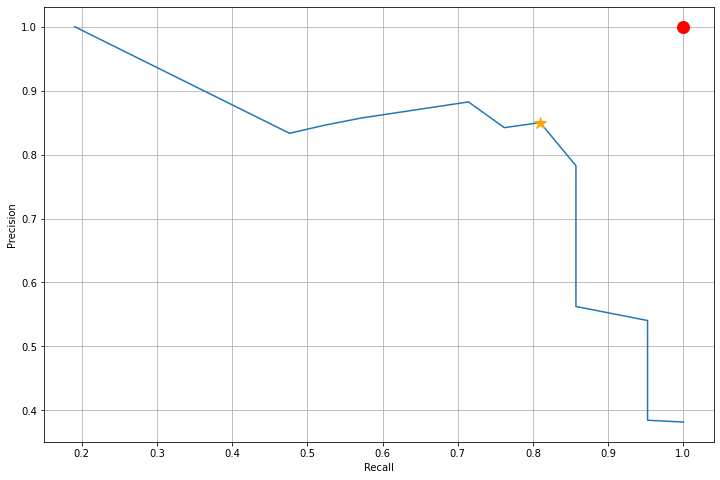

In [5]:
## Visualizing the precision-recall curve for Model #1

## Printing the optimal recall, precision, cutoff
print(cutoff[['Recall', 'Precision', 'Cutoff']][0:1])

plt.figure(figsize = (12,8))
plt.plot(recall[:-1], precision[:-1])
plt.plot([1], 1, 'o', color = 'Red', markersize = 12)
plt.plot([cutoff['Recall'][0]], cutoff['Precision'][0], '*', color = 'Orange', markersize = 12)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

In [6]:
## ii) Model #2 - AdaBoost Classifier

## Building the model
md2 = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 5), n_estimators = 500,
                        learning_rate = 0.01).fit(X_smote, Y_smote)

## Predicting on the test set
md2_preds = md2.predict_proba(X_test)[:, 1]

## Computing the precision-recall curve to estimate the optimal cut-off value
precision, recall, cutoff = precision_recall_curve(Y_test, md2_preds)

## Creating the data frame to store values
cutoff = pd.DataFrame({'Precision': precision[:-1], 'Recall': recall[:-1], 'Cutoff': cutoff})

## Using the distance formula to find the optimal cutoff (precision = 1.0, recall = 1.0)
cutoff['Precision_minus_1'] = cutoff['Precision'] - 1
cutoff['Recall_minus_1'] = cutoff['Recall'] - 1

cutoff['Distance'] = np.sqrt(cutoff['Recall_minus_1']**2 + cutoff['Precision_minus_1']**2)

## Sorting the data frame and extracting the threshold value with the minimal distance
cutoff = cutoff.sort_values(by = 'Distance', ascending = True).reset_index(drop = True)

## Extracting optimal cutoff
cutoff_val = cutoff['Cutoff'][0]
print('Optimal Cut-off Value:', cutoff_val, '\n')

## Changing likelihoods to labels with new cutoff value
md2_preds_label = np.where(md2_preds < cutoff_val, 0, 1)

## Printing the F1-Score
print('F1-Score:', f1_score(Y_test, md2_preds_label))

Optimal Cut-off Value: 0.16277556126928866 

F1-Score: 0.923076923076923


     Recall  Precision    Cutoff
0  0.857143        1.0  0.162776


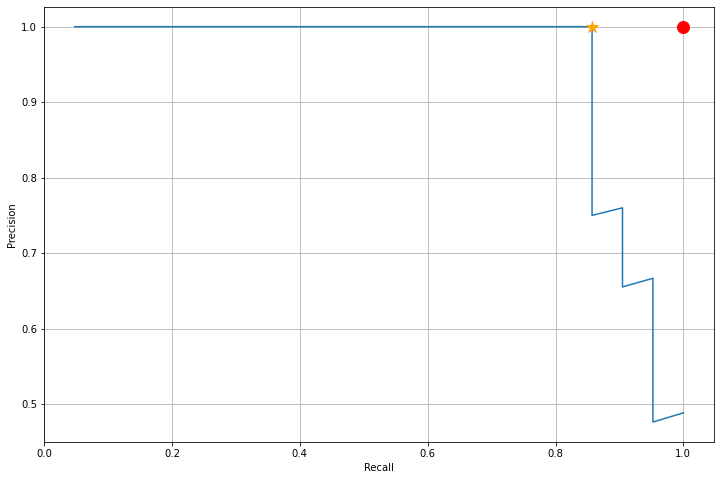

In [7]:
## Visualizing the precision-recall curve for Model #2

## Printing the optimal recall, precision, cutoff
print(cutoff[['Recall', 'Precision', 'Cutoff']][0:1])

plt.figure(figsize = (12,8))
plt.plot(recall[:-1], precision[:-1])
plt.plot([1], 1, 'o', color = 'Red', markersize = 12)
plt.plot([cutoff['Recall'][0]], cutoff['Precision'][0], '*', color = 'Orange', markersize = 12)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

In [8]:
## c) Repeating steps (a) and (b) 100 times:

## Creating empty lists to store results
rf_score = []
ada_score = []

## Defining the input and target variables
X = train[['trustLevel', 'scannedLineItemsPerSecond', 'totalScanTimeInSeconds', 'lineItemVoidsPerPosition', 'valuePerSecond']]
Y = train['fraud']


## Repeating the steps 100 times
for i in tqdm(range(0, 100)):
    
    ## Splitting the data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
    
    ## Using the training data-frame to create a SMOTE data-frame
    X_smote, Y_smote = SMOTE().fit_resample(X_train, Y_train)
    
    
    ##############
    ## Model #1 ##
    ##############
    
    ## Building the model
    rf_md = RandomForestClassifier(n_estimators = 500, max_depth = 5).fit(X_smote, Y_smote)
    
    ## Predicting on the test set
    rf_preds = rf_md.predict_proba(X_test)[:, 1]

    ## Computing the precision_recall_curve
    precision, recall, threshold = precision_recall_curve(Y_test, rf_preds)
    
    ## Creating a data frame to store results
    rf_cutoff = pd.DataFrame({'Precision': precision[:-1], 'Recall': recall[:-1], 'Cutoff': threshold})
    
    ## Using the distance formula to find the optimal cutoff (precision = 1.0, recall = 1.0)
    rf_cutoff['Precision_minus_1'] = rf_cutoff['Precision'] - 1
    rf_cutoff['Recall_minus_1'] = rf_cutoff['Recall'] - 1
    
    rf_cutoff['Distance'] = np.sqrt(rf_cutoff['Precision_minus_1']**2 + rf_cutoff['Recall_minus_1']**2)
    
    ## Sorting the data frame and extracting the optimal cutoff value
    rf_cutoff = rf_cutoff.sort_values(by = 'Distance', ascending = True).reset_index(drop = True)
    
    ## Extracting optimal cutoff
    rf_cutoff_val = rf_cutoff['Cutoff'][0]
    
    ## Changing likelihoods to labels with new cutoff value
    rf_preds_label = np.where(rf_preds < rf_cutoff_val, 0, 1)
    
    ## Appening the F1-Score
    rf_score.append(f1_score(Y_test, rf_preds_label))
    
    
    ##############
    ## Model #2 ##
    ##############
    
    ## Building the model
    ada_md = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 5), n_estimators = 500,
                                learning_rate = 0.01).fit(X_smote, Y_smote)
    
    ## Predicting on the test set
    ada_preds = ada_md.predict_proba(X_test)[:, 1]
    
    ## Computing the precision-recall curve to estimate the optimal cut-off value
    precision, recall, cutoff = precision_recall_curve(Y_test, ada_preds)
    
    ## Creating the data frame to store values
    ada_cutoff = pd.DataFrame({'Precision': precision[:-1], 'Recall': recall[:-1], 'Cutoff': cutoff})
    
    ## Using the distance formula to find the optimal cutoff (precision = 1.0, recall = 1.0)
    ada_cutoff['Precision_minus_1'] = ada_cutoff['Precision'] - 1
    ada_cutoff['Recall_minus_1'] = ada_cutoff['Recall'] - 1
    
    ada_cutoff['Distance'] = np.sqrt(ada_cutoff['Recall_minus_1']**2 + ada_cutoff['Precision_minus_1']**2)
    
    ## Sorting the data frame and extracting the threshold value with the minimal distance
    ada_cutoff = ada_cutoff.sort_values(by = 'Distance', ascending = True).reset_index(drop = True)
    
    ## Extracting optimal cutoff
    ada_cutoff_val = ada_cutoff['Cutoff'][0]
    
    ## Changing likelihoods to labels with new cutoff value
    ada_preds_label = np.where(ada_preds < ada_cutoff_val, 0, 1)
    
    ## Appening the F1-Score
    ada_score.append(f1_score(Y_test, ada_preds_label))
    
    
## Printing the mean performance of each model type
print('Random Forest Classifier: Mean F1-Score =', np.mean(rf_score))
print('AdaBoost Classifier: Mean F1-Score =', np.mean(ada_score))

100%|██████████| 100/100 [08:19<00:00,  4.99s/it]

Random Forest Classifier: Mean F1-Score = 0.7138989995280194
AdaBoost Classifier: Mean F1-Score = 0.7815512641962798


In [ ]:
## Based on part (c), we would use the AdaBoost Classifier model to predict customer fraud becuase it has a 
## slightly higher mean F1-Score. 